![Image](https://cdn-images-1.medium.com/max/2400/1*LmxW8FDfXZJl5yvESvjP7Q.jpeg)

<left><h1>Handwritten Digits Classifier</h1></left>

In this project, we'll:
* explore why image classification is a hard task
* observe the limitations of traditional machine learning models for image classification
* train, test, and improve a few different deep neural networks for image classification

### Introduction

The `sklearn` library has built-in function that returns the exact copy of [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI.

In [1]:
from sklearn.datasets import load_digits
digits = load_digits(as_frame=True)
print(digits.data.shape)

(1797, 64)


In [2]:
digits.frame.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


The data set has **1797** images are represented as a row of pixel values. Since each row contain **64** values our images have **8x8** resolution.

Let's display some of them using `matplotlib`.

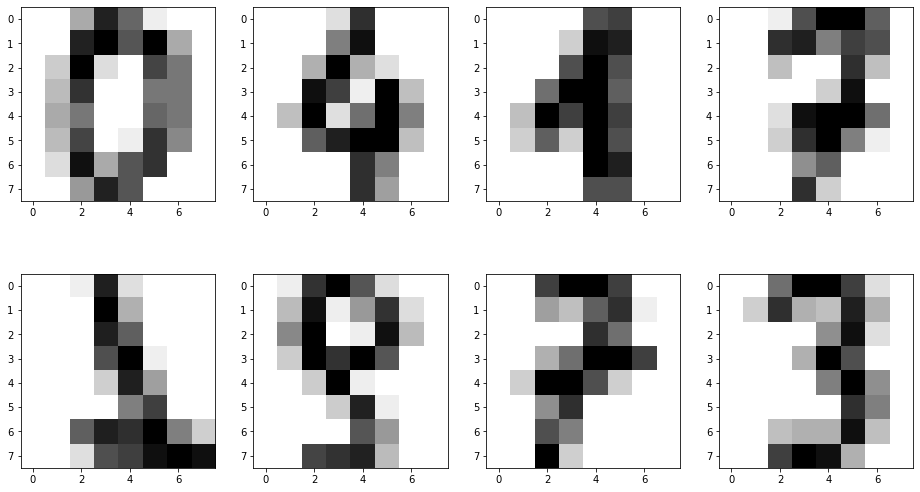

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

fix, axs = plt.subplots(2, 4, figsize=(16,9))
digits_df = digits.data
bias = 0

for row in range(2):
    for col in range(4):
        #Calculate index for each image
        #It would be 1100 for second bottom image for exaple 
        index = col * 100 + bias
        image = digits_df.iloc[index].values.reshape(8,8)
        axs[row, col].imshow(image, cmap='gray_r')
        
    bias = 1000

### KNN classifier

Due to there is no linearity between image's pixels and an actiual digit we'll use the k-nearest neighbors algorithm here. The `KNeighborsClassifier` to be precise.

Let's define a few functions and run them with **k=5** and **folds=4**.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def train_test(train_set, test_set, k, how='train'):
    #trains and tests k-nearest neighbors models with different k
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_set.iloc[:, :-1], train_set['target'])
    
    #uses train or test sets in predict() depending on how
    if how == 'train':
        prediction = knn.predict(train_set.iloc[:, :-1])
        accuracy = accuracy_score(train_set['target'], prediction)
        return accuracy
    
    elif how == 'test':
        prediction = knn.predict(test_set.iloc[:, :-1])
        accuracy = accuracy_score(test_set['target'], prediction)
        return accuracy
    
def cross_validate(data, k, how='train'):
    #performs 4-fold cross validation using train() and test()
    #returns overall accuracy
    
    kf = KFold(n_splits=4,
              shuffle=True,
              random_state=0)
    
    accuracies = []
    
    for train_index, test_index in kf.split(data):
        
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]

        accuracy = train_test(train_set, test_set, k, how)
        accuracies.append(accuracy)
        
    return np.mean(accuracies)

cross_validate(digits.frame, 5)

0.990725350762988

Now let's iterate number of neigbors and build a plot for computed accuracies.

In [33]:
knn_accuracies = pd.DataFrame(index=range(1,16), columns=['train', 'test'])

methods = ['train', 'test']

#Iterate over both methods and 15 neigbors numbers
for how in methods:
    for k in range(1,16):
        accuracy = cross_validate(digits.frame, k, how)
        knn_accuracies.loc[k, how] = accuracy
    
knn_accuracies

,train,test
1,1.0,0.986642
2,0.991838,0.981634
3,0.993322,0.984417
4,0.991838,0.982751
5,0.990725,0.982194
6,0.989613,0.981639
7,0.989984,0.982195
8,0.987572,0.983309
9,0.987943,0.983309
10,0.985346,0.980526


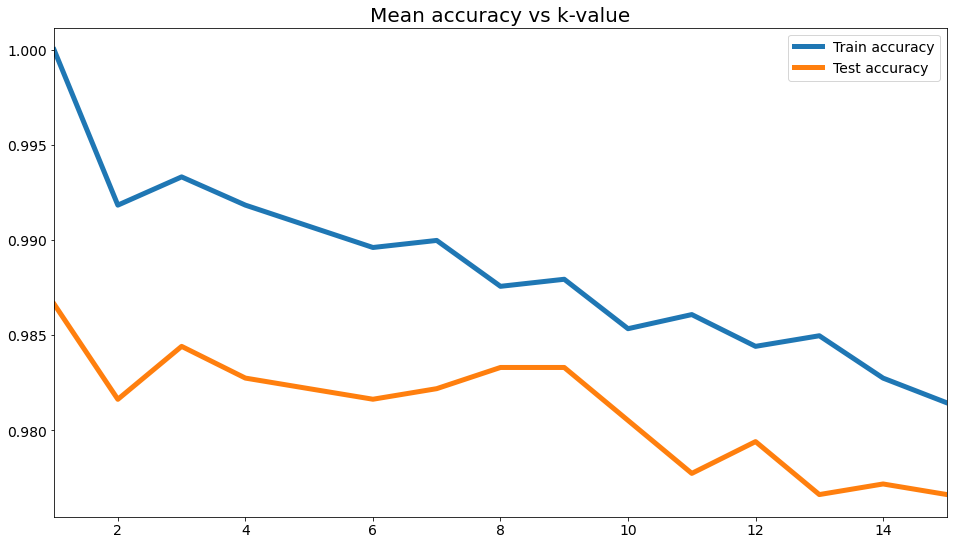

In [6]:
fig, ax = plt.subplots(figsize=(16,9))

for col in knn_accuracies.columns:
    ax.plot(knn_accuracies[col],
           lw=5)

#decorations
ax.set_xlim(1, 15)
ax.set_title('Mean accuracy vs k-value', fontsize=20)
ax.tick_params(labelsize=14)
ax.legend(['Train accuracy', 'Test accuracy'],
         fontsize=14)

It seems the best result is **0.986** with **k=1**. Increasing k-value doesn't make our predictions more accurate.

Also we can observe the difference between train and test accurecies which is pretty low (less the 1.4%). There is no overfitting so.

### MLP classifier

There are a few downsides to using k-nearest neighbors:
* high memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
* no model representation to debug and explore

Considering this we'll try a neural network with a single hidden layer but with different number of neurons. We'll keep using cross validation with 4 folds at this try aswell.

In [8]:
from sklearn.neural_network import MLPClassifier

def mlp_cross_val(data, n, how='train'):
    #performs 4-fold cross validation using MLPClassifier
    #returns overall accuracy
    
    kf = KFold(n_splits=4,
              shuffle=True,
              random_state=0)
    
    accuracies = []
    
    for train_index, test_index in kf.split(data):
        
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
        
        mlp_class = MLPClassifier(hidden_layer_sizes=(n,),
                                  max_iter=1000,
                                  learning_rate_init=0.002,
                                 random_state=2)
        
        mlp_class.fit(train_set.iloc[:, :-1], train_set['target'])
        
        #uses train or test sets in predict() depending on how
        if how == 'train':
            prediction = mlp_class.predict(train_set.iloc[:, :-1])
            accuracy = accuracy_score(train_set['target'], prediction)

        elif how == 'test':
            prediction = mlp_class.predict(test_set.iloc[:, :-1])
            accuracy = accuracy_score(test_set['target'], prediction)

        accuracies.append(accuracy)
        
    return np.mean(accuracies)

Now we've got `mlp_cross_val()` func, let's iterate through different neurons number.

In [32]:
indecies = np.around(np.geomspace(8, 256, num=6)).astype(int) #also neurons numbers

neurons_accuracies = pd.DataFrame(index=indecies, columns=['train', 'test'])

#Iterate over both methods and 6 neurons numbers
for how in methods:
    for neuron in indecies:
        accuracy = mlp_cross_val(digits.frame, neuron, how)
        neurons_accuracies.loc[neuron, how] = accuracy

neurons_accuracies

,train,test
8,0.999629,0.944907
16,1.0,0.958822
32,1.0,0.971618
64,1.0,0.97496
128,1.0,0.97663
256,1.0,0.98331


And now we'll build a plot.

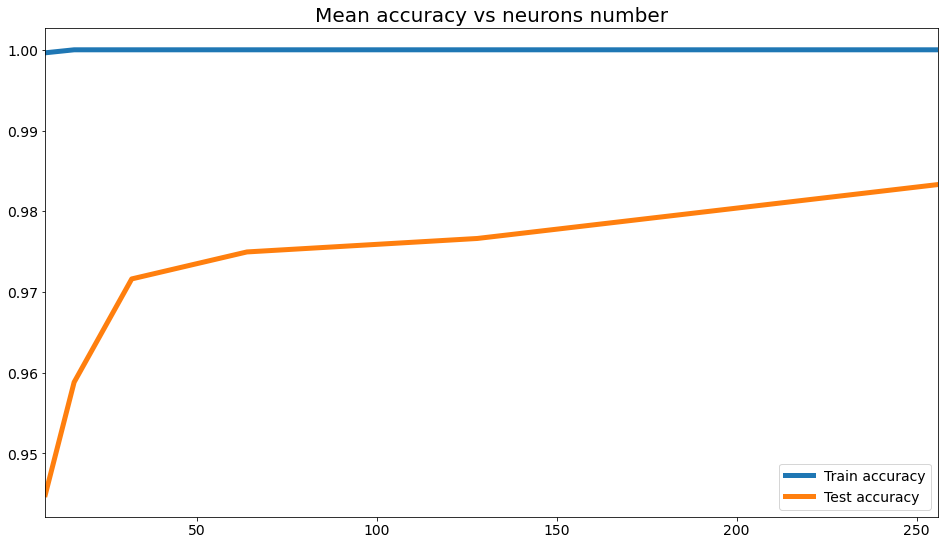

In [36]:
fig, ax = plt.subplots(figsize=(16,9))

for col in neurons_accuracies.columns:
    ax.plot(neurons_accuracies[col],
           lw=5)

#decorations
ax.set_xlim(8, 256)
ax.set_title('Mean accuracy vs neurons number', fontsize=20)
ax.tick_params(labelsize=14)
ax.legend(['Train accuracy', 'Test accuracy'],
         fontsize=14)

Our model's reached **accuracy=1** pretty fast on train set while it's far away from 1 on test set. It's an actual overfitting.

## Multilayer network